In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# List of all object categories in the IMAGENET dataset

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [ ]:
print("Hallo!")

Hallo!


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [ ]:
import urllib.request
#URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
#fname = "hymenoptera_data.zip"
URL = "http://www.juergenbrauer.org/datasets/messy_vs_clean_rooms.zip"
fname = "messy_vs_clean_rooms.zip"
urllib.request.urlretrieve(URL, fname)

('messy_vs_clean_rooms.zip', <http.client.HTTPMessage at 0x7a863b76f970>)

In [ ]:
import shutil
shutil.unpack_archive(fname)

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (687 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree --filelimit 5 images/

images/
├── images
│   ├── test  [10 entries exceeds filelimit, not opening dir]
│   ├── train
│   │   ├── clean  [96 entries exceeds filelimit, not opening dir]
│   │   └── messy  [96 entries exceeds filelimit, not opening dir]
│   └── val
│       ├── clean  [10 entries exceeds filelimit, not opening dir]
│       └── messy  [10 entries exceeds filelimit, not opening dir]
├── test  [10 entries exceeds filelimit, not opening dir]
├── train
│   ├── clean  [96 entries exceeds filelimit, not opening dir]
│   └── messy  [96 entries exceeds filelimit, not opening dir]
└── val
    ├── clean  [10 entries exceeds filelimit, not opening dir]
    └── messy  [10 entries exceeds filelimit, not opening dir]

15 directories, 0 files


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
image_datasets["train"]

Dataset ImageFolder
    Number of datapoints: 192
    Root location: images/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets["val"]

Dataset ImageFolder
    Number of datapoints: 20
    Root location: images/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



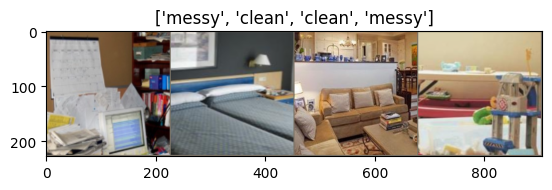

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [ ]:
classes

tensor([1, 0, 0, 1])

In [ ]:
class_names

['clean', 'messy']

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
'ABC' * 10

'ABCABCABCABCABCABCABCABCABCABC'

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [ ]:
import torchvision

In [ ]:
type(torchvision)

module

In [ ]:
type( torchvision.models )

module

In [ ]:
type( torchvision.models.resnet18 )

function

In [ ]:
class A:
  def __init__(self,x):
    self.x = x

In [ ]:
a1 = A(42.0)

In [ ]:
type(a1)

__main__.A

In [ ]:
#model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = models.resnet18(weights=None)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
type(models)

module

In [ ]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet18.fc.in_features

512

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6432 Acc: 0.6302
val Loss: 0.8663 Acc: 0.6000

Epoch 1/24
----------
train Loss: 0.7088 Acc: 0.5833
val Loss: 0.7145 Acc: 0.6500

Epoch 2/24
----------
train Loss: 0.6452 Acc: 0.6667
val Loss: 1.0183 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.8148 Acc: 0.6458
val Loss: 0.5042 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.7092 Acc: 0.6875
val Loss: 1.1802 Acc: 0.5500

Epoch 5/24
----------
train Loss: 0.7362 Acc: 0.6667
val Loss: 0.7532 Acc: 0.5500

Epoch 6/24
----------
train Loss: 0.7011 Acc: 0.6562
val Loss: 0.4491 Acc: 0.7500

Epoch 7/24
----------
train Loss: 0.5464 Acc: 0.7292
val Loss: 0.4270 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.5517 Acc: 0.7448
val Loss: 0.4157 Acc: 0.8000

Epoch 9/24
----------
train Loss: 0.5878 Acc: 0.7135
val Loss: 0.4184 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.5359 Acc: 0.7396
val Loss: 0.4285 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.5319 Acc: 0.7448
val Loss: 0.4372 Acc: 0.8500

Epoch 12/24
----------
t

In [ ]:
38/40

0.95

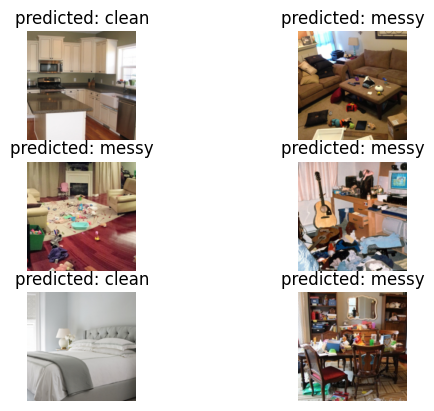

In [ ]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [ ]:
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')

import torchsummary
resnet18 = resnet18.to(device)
torchsummary.summary(resnet18, input_size=(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [ ]:
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
#for param in resnet18.parameters():
#    print(param.requires_grad)
#    #param.requires_grad = False
for name, param in resnet18.named_parameters():
    print(f"Schicht: {name}, Trainierbar: {param.requires_grad}")

Schicht: conv1.weight, Trainierbar: True
Schicht: bn1.weight, Trainierbar: True
Schicht: bn1.bias, Trainierbar: True
Schicht: layer1.0.conv1.weight, Trainierbar: True
Schicht: layer1.0.bn1.weight, Trainierbar: True
Schicht: layer1.0.bn1.bias, Trainierbar: True
Schicht: layer1.0.conv2.weight, Trainierbar: True
Schicht: layer1.0.bn2.weight, Trainierbar: True
Schicht: layer1.0.bn2.bias, Trainierbar: True
Schicht: layer1.1.conv1.weight, Trainierbar: True
Schicht: layer1.1.bn1.weight, Trainierbar: True
Schicht: layer1.1.bn1.bias, Trainierbar: True
Schicht: layer1.1.conv2.weight, Trainierbar: True
Schicht: layer1.1.bn2.weight, Trainierbar: True
Schicht: layer1.1.bn2.bias, Trainierbar: True
Schicht: layer2.0.conv1.weight, Trainierbar: True
Schicht: layer2.0.bn1.weight, Trainierbar: True
Schicht: layer2.0.bn1.bias, Trainierbar: True
Schicht: layer2.0.conv2.weight, Trainierbar: True
Schicht: layer2.0.bn2.weight, Trainierbar: True
Schicht: layer2.0.bn2.bias, Trainierbar: True
Schicht: layer2.0.d

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

for param in model_conv.parameters():
    print(param.requires_grad)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
torchsummary.summary(model_conv, input_size=(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [ ]:
for name, param in model_conv.named_parameters():
    print(f"Schicht: {name}, Trainierbar: {param.requires_grad}")

Schicht: conv1.weight, Trainierbar: False
Schicht: bn1.weight, Trainierbar: False
Schicht: bn1.bias, Trainierbar: False
Schicht: layer1.0.conv1.weight, Trainierbar: False
Schicht: layer1.0.bn1.weight, Trainierbar: False
Schicht: layer1.0.bn1.bias, Trainierbar: False
Schicht: layer1.0.conv2.weight, Trainierbar: False
Schicht: layer1.0.bn2.weight, Trainierbar: False
Schicht: layer1.0.bn2.bias, Trainierbar: False
Schicht: layer1.1.conv1.weight, Trainierbar: False
Schicht: layer1.1.bn1.weight, Trainierbar: False
Schicht: layer1.1.bn1.bias, Trainierbar: False
Schicht: layer1.1.conv2.weight, Trainierbar: False
Schicht: layer1.1.bn2.weight, Trainierbar: False
Schicht: layer1.1.bn2.bias, Trainierbar: False
Schicht: layer2.0.conv1.weight, Trainierbar: False
Schicht: layer2.0.bn1.weight, Trainierbar: False
Schicht: layer2.0.bn1.bias, Trainierbar: False
Schicht: layer2.0.conv2.weight, Trainierbar: False
Schicht: layer2.0.bn2.weight, Trainierbar: False
Schicht: layer2.0.bn2.bias, Trainierbar: Fals

In [ ]:
model_conv.fc.weight

Parameter containing:
tensor([[-0.0384,  0.0346,  0.0384,  ..., -0.0219,  0.0126, -0.0174],
        [ 0.0003, -0.0293, -0.0405,  ...,  0.0382,  0.0002, -0.0394]],
       device='cuda:0', requires_grad=True)

In [ ]:
model_conv.fc.bias

Parameter containing:
tensor([ 0.0268, -0.0141], device='cuda:0', requires_grad=True)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5445 Acc: 0.6926
val Loss: 0.2735 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4315 Acc: 0.8033
val Loss: 0.1631 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.5843 Acc: 0.7500
val Loss: 0.2744 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5388 Acc: 0.7500
val Loss: 0.1666 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.4815 Acc: 0.8033
val Loss: 0.2183 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.7545 Acc: 0.7377
val Loss: 0.2281 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4277 Acc: 0.8115
val Loss: 0.1542 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.2914 Acc: 0.8730
val Loss: 0.1548 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4291 Acc: 0.8074
val Loss: 0.1753 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2975 Acc: 0.8934
val Loss: 0.1580 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3366 Acc: 0.8525
val Loss: 0.1598 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3734 Acc: 0.8484
val Loss: 0.1590 Acc: 0.9608

Epoch 12/24
----------
t

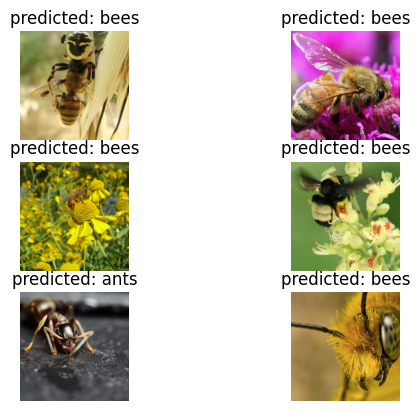

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    print("Tensor Shape vor unsqueeze:", img.shape)
    img = img.unsqueeze(0)
    print("Tensor Shape nach unsqueeze:", img.shape)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

Tensor Shape vor unsqueeze: torch.Size([3, 224, 224])
Tensor Shape nach unsqueeze: torch.Size([1, 3, 224, 224])


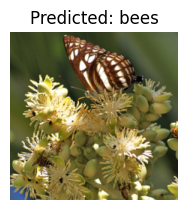

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

# Visualisierung des finalen Modells (ResNet18+Klassifikator für 2 Klassen)

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=d7b1186e1b79be5b312ca19d565cca2f9013b539d74d64c78f4b36fd49992270
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
from torchvision.models import resnet18
from torchviz import make_dot

# Erstellen des ResNet18-Modells
model = resnet18()

# Erstellen eines Beispieldatensatzes (Dummy-Input)
input_tensor = torch.rand(1, 3, 224, 224)

# Ausführen des Modells, um einen Output zu erhalten
output = model(input_tensor)

# Erstellen des Graphen
dot = make_dot(output, params=dict(model.named_parameters()))

# Speichern des Graphen als PDF
dot.render('resnet18_graph', format='pdf')


'resnet18_graph.pdf'

In [ ]:
!pip show tensorboard

Name: tensorboard
Version: 2.14.1
Summary: TensorBoard lets you watch Tensors Flow
Home-page: https://github.com/tensorflow/tensorboard
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, google-auth, google-auth-oauthlib, grpcio, markdown, numpy, protobuf, requests, setuptools, six, tensorboard-data-server, werkzeug
Required-by: tensorflow


In [ ]:
!date

Thu Nov 30 10:03:08 AM UTC 2023


In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet18

%load_ext tensorboard

# Initialisieren des SummaryWriter
writer = SummaryWriter()

# Erstellen des ResNet18-Modells
model = resnet18()

# Erstellen eines Beispieldatensatzes (Dummy-Input)
# Die Größe des Inputs sollte der erwarteten Eingabegröße des Modells entsprechen.
input_tensor = torch.rand(1, 3, 224, 224)

# Hinzufügen des Modells zum Writer
writer.add_graph(model, input_tensor)

# Schließen des Writers
writer.close()


In [ ]:
models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

# Wie unterscheidet sich ein vortrainiertes von einem nicht-vortrainierten Modell?

9408
9408


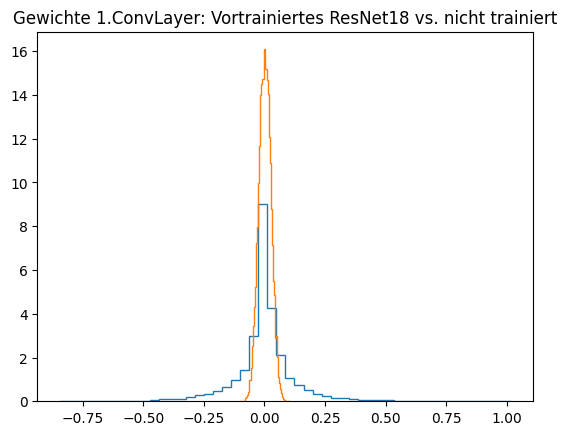

In [ ]:
resnet18_pretrained = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet18_nottrained = torchvision.models.resnet18(weights=None)


all_weights_pretrained = list( resnet18_pretrained.named_parameters() )
all_weights_nottrained = list( resnet18_nottrained.named_parameters() )
first_layer_weights_pretrained = all_weights_pretrained[0][1]
first_layer_weights_nottrained = all_weights_nottrained[0][1]

print( len(first_layer_weights_pretrained.flatten()) )
print( len(first_layer_weights_nottrained.flatten()) )


import matplotlib.pyplot as plt
plt.hist( first_layer_weights_pretrained.flatten().detach(), bins=50, density=True, histtype="step" )
plt.hist( first_layer_weights_nottrained.flatten().detach(), bins=50, density=True, histtype="step" )
plt.title( "Gewichte 1.ConvLayer: Vortrainiertes ResNet18 vs. nicht trainiert" )
plt.show()



## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



